<a href="https://colab.research.google.com/github/AOdrio/Datathon/blob/main/Primer%20intento%20-%20en%20limpio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

import xgboost as xgb
from matplotlib import pyplot as plt
import seaborn as sns # for correlation heatmap

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression as LR
from sklearn.neighbors import KNeighborsRegressor as KNN

SEED = 42

In [2]:
url='https://drive.google.com/file/d/1KH1fB83JDAWcMRCHKFf9SmcGH7MQkupE/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
df_original = pd.read_csv(url)

In [ ]:
#df_original.head()

In [ ]:
print (df_original.isnull().sum())

se remplazan los null por la media de la columna

In [3]:
edad_media = df_original['edad'].mean()
edad_media

45.02159532392986

In [4]:
def transfromar_DataFrame (df):
  df = df.copy()
  df = df.drop(df.columns[0],axis=1)
  #Remplazar nulls de la edad con la media de la columna
  df['edad'] = df['edad'].fillna(edad_media, inplace=False)

  #Transformar categóricas en numéricas
  df['peorcalificacionBCU'] = (df['peorcalificacionBCU'].
                              str.replace('2B','3').
                              str.replace('5','6').
                              str.replace('4','5').
                              str.replace('3','4').
                              str.replace('2A','2').
                              str.replace('1C','1').
                              str.replace('1A','0'))
  df['peorcalificacionBCU'] = pd.to_numeric(df['peorcalificacionBCU'], downcast='integer')
  return df

In [5]:
df = transfromar_DataFrame(df_original)


In [ ]:
#df.head()

In [6]:
y = df.pop("ingreso")
X = df.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [9]:
# La linea base es el promedio de los ingresos
baseline_preds = pd.DataFrame(y_train.copy())
media = y_train.mean()
baseline_preds['media'] = media
# Baseline errors, and display average baseline error
baseline_MAPE = MAPE(y_train,baseline_preds['media'])
print('MAPE linea base: ', round(baseline_MAPE *100, 2),'%')

MAPE linea base:  58.03 %


In [10]:
rf = RandomForestRegressor(n_estimators = 500, random_state = SEED)

In [11]:
rf.fit(X_train,y_train)
preds_rf = rf.predict(X_test)
MAPE_rf = MAPE(y_test, preds_rf)
print('MAPE_rf:', round(100*MAPE_rf, 2),'%')

MAPE_rf: 12.93 %


Text(0.5, 0, 'Xgboost Feature Importance')

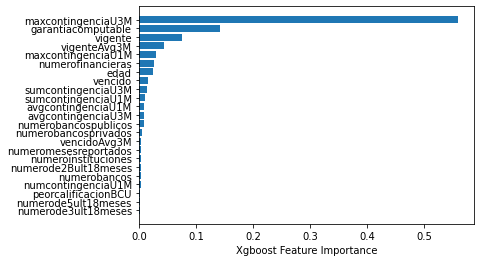

In [12]:
sorted_idx = rf.feature_importances_.argsort()
plt.barh(list(X_train.columns[sorted_idx]), rf.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")

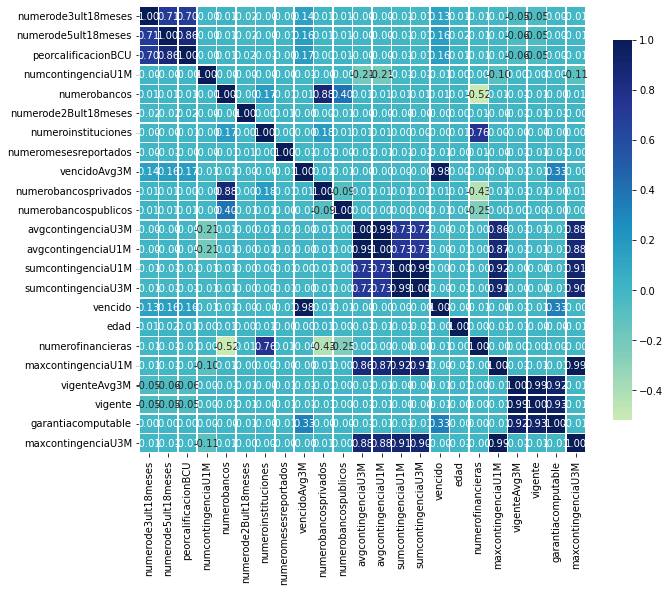

In [13]:
def correlation_heatmap(train):
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', cmap="YlGnBu",
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70}
                )
    plt.show();
    
correlation_heatmap(X_train[list(X_train.columns[sorted_idx])])

In [14]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [15]:
params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:linear',
    'eval_metric':'mae',
    'tree_method' : 'gpu_hist',
    'verbosity':0
}

In [16]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=999,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[0]	Test-mae:47179.6
Will train until Test-mae hasn't improved in 10 rounds.
[1]	Test-mae:33009.5
[2]	Test-mae:23499.8
[3]	Test-mae:17619.1
[4]	Test-mae:14238.5
[5]	Test-mae:12490.9
[6]	Test-mae:11602
[7]	Test-mae:11150.9
[8]	Test-mae:10971.3
[9]	Test-mae:10836.5
[10]	Test-mae:10703.3
[11]	Test-mae:10600.3
[12]	Test-mae:10571.4
[13]	Test-mae:10530.6
[14]	Test-mae:10490.4
[15]	Test-mae:10409.7
[16]	Test-mae:10361.5
[17]	Test-mae:10350
[18]	Test-mae:10303.9
[19]	Test-mae:10264.7
[20]	Test-mae:10233.4
[21]	Test-mae:10225
[22]	Test-mae:10207.5
[23]	Test-mae:10198.1
[24]	Test-mae:10165.7
[25]	Test-mae:10149.7
[26]	Test-mae:10142.8
[27]	Test-mae:10128.4
[28]	Test-mae:10137.6
[29]	Test-mae:10129.3
[30]	Test-mae:10140.8
[31]	Test-mae:10137.1
[32]	Test-mae:10148.1
[33]	Test-mae:10153.9
[34]	Test-mae:10107.9
[35]	Test-mae:10111.3
[36]	Test-mae:10107.1
[37]	Test-mae:10075.4
[38]	Test-mae:10046.8
[39]	Test-mae:10049.3
[40]	Test-mae:10043
[41]	Test-mae:10052
[42]	Test-mae:10057.2
[43]	Test-mae:1003

In [17]:
print("Best MAE: {:.2f} with {} rounds".format(
                 model.best_score,
                 model.best_iteration+1))

Best MAE: 10029.66 with 49 rounds


In [18]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(9,12)
    for min_child_weight in range(5,8)
]

In [19]:
# Define initial best params and MAE
min_mae = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=999,
        seed=SEED,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )    # Update best MAE
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth,min_child_weight)
    
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with max_depth=9, min_child_weight=5
	MAE 10341.4634766 for 26 rounds
CV with max_depth=9, min_child_weight=6
	MAE 10332.5218748 for 17 rounds
CV with max_depth=9, min_child_weight=7
	MAE 10319.5048826 for 31 rounds
CV with max_depth=10, min_child_weight=5
	MAE 10441.352929600002 for 28 rounds
CV with max_depth=10, min_child_weight=6
	MAE 10376.188085799999 for 16 rounds
CV with max_depth=10, min_child_weight=7
	MAE 10380.113672000001 for 12 rounds
CV with max_depth=11, min_child_weight=5
	MAE 10389.2917968 for 13 rounds
CV with max_depth=11, min_child_weight=6
	MAE 10339.743945399998 for 12 rounds
CV with max_depth=11, min_child_weight=7
	MAE 10403.668163999999 for 13 rounds
Best params: 9, 7, MAE: 10319.5048826


In [20]:
params['max_depth'] = 9
params['min_child_weight'] = 7

In [21]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,10)]
    for colsample in [i/10. for i in range(7,10)]
]

In [22]:
min_mae = float("Inf")
best_params = None
# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))    
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample    
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=999,
        seed=SEED,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )  
    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (subsample,colsample)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with subsample=0.9, colsample=0.9
	MAE 10441.9560546 for 13 rounds
CV with subsample=0.9, colsample=0.8
	MAE 10489.499218599998 for 26 rounds
CV with subsample=0.9, colsample=0.7
	MAE 10587.284375 for 29 rounds
CV with subsample=0.8, colsample=0.9
	MAE 10496.9210938 for 13 rounds
CV with subsample=0.8, colsample=0.8
	MAE 10513.094726399999 for 17 rounds
CV with subsample=0.8, colsample=0.7
	MAE 10648.048242199999 for 14 rounds
CV with subsample=0.7, colsample=0.9
	MAE 10502.121875199999 for 14 rounds
CV with subsample=0.7, colsample=0.8
	MAE 10576.718164200001 for 14 rounds
CV with subsample=0.7, colsample=0.7
	MAE 10712.1580078 for 14 rounds
Best params: 0.9, 0.9, MAE: 10441.9560546


In [23]:
params['subsample'] = 0.9
params['colsample_bytree'] = 0.9

In [24]:
# This can take some time…
min_mae = float("Inf")
best_params = None
for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))    
    # We update our parameters
    params['eta'] = eta    
    # Run and time CV
    cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round=999,
            seed=SEED,
            nfold=5,
            metrics=['mae'],
            early_stopping_rounds=10
          )    
    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds\n".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = eta
print("Best params: {}, MAE: {}".format(best_params, min_mae))

CV with eta=0.3
	MAE 10441.9560546 for 13 rounds

CV with eta=0.2
	MAE 10263.2039062 for 29 rounds

CV with eta=0.1
	MAE 10148.1013672 for 52 rounds

CV with eta=0.05
	MAE 10108.3935546 for 103 rounds

CV with eta=0.01
	MAE 10059.802929599999 for 526 rounds

CV with eta=0.005
	MAE 10058.4427734 for 998 rounds

Best params: 0.005, MAE: 10058.4427734


In [25]:
params['eta'] = 0.01

In [26]:
params

{'colsample_bytree': 0.9,
 'eta': 0.01,
 'eval_metric': 'mae',
 'max_depth': 9,
 'min_child_weight': 7,
 'objective': 'reg:linear',
 'subsample': 0.9,
 'tree_method': 'gpu_hist',
 'verbosity': 0}

In [27]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=999,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[0]	Test-mae:66823.3
Will train until Test-mae hasn't improved in 10 rounds.
[1]	Test-mae:66159
[2]	Test-mae:65501.8
[3]	Test-mae:64849.1
[4]	Test-mae:64205.4
[5]	Test-mae:63566.6
[6]	Test-mae:62932.3
[7]	Test-mae:62306
[8]	Test-mae:61686.3
[9]	Test-mae:61071.5
[10]	Test-mae:60463.3
[11]	Test-mae:59859.6
[12]	Test-mae:59260.5
[13]	Test-mae:58672.2
[14]	Test-mae:58087.3
[15]	Test-mae:57508.9
[16]	Test-mae:56935.9
[17]	Test-mae:56370
[18]	Test-mae:55808
[19]	Test-mae:55249.4
[20]	Test-mae:54700.1
[21]	Test-mae:54156.3
[22]	Test-mae:53616.6
[23]	Test-mae:53083.7
[24]	Test-mae:52557.5
[25]	Test-mae:52036.2
[26]	Test-mae:51517.4
[27]	Test-mae:51003.3
[28]	Test-mae:50495.7
[29]	Test-mae:49995.3
[30]	Test-mae:49496
[31]	Test-mae:49002.4
[32]	Test-mae:48513.7
[33]	Test-mae:48031.6
[34]	Test-mae:47555.4
[35]	Test-mae:47083
[36]	Test-mae:46615.9
[37]	Test-mae:46154.8
[38]	Test-mae:45694
[39]	Test-mae:45239.7
[40]	Test-mae:44788.5
[41]	Test-mae:44340.7
[42]	Test-mae:43902.2
[43]	Test-mae:43464.6


In [28]:
num_boost_round = model.best_iteration + 1
best_model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")]
)

[0]	Test-mae:66823.3
[1]	Test-mae:66159
[2]	Test-mae:65501.8
[3]	Test-mae:64849.1
[4]	Test-mae:64205.4
[5]	Test-mae:63566.6
[6]	Test-mae:62932.3
[7]	Test-mae:62306
[8]	Test-mae:61686.3
[9]	Test-mae:61071.5
[10]	Test-mae:60463.3
[11]	Test-mae:59859.6
[12]	Test-mae:59260.5
[13]	Test-mae:58672.2
[14]	Test-mae:58087.3
[15]	Test-mae:57508.9
[16]	Test-mae:56935.9
[17]	Test-mae:56370
[18]	Test-mae:55808
[19]	Test-mae:55249.4
[20]	Test-mae:54700.1
[21]	Test-mae:54156.3
[22]	Test-mae:53616.6
[23]	Test-mae:53083.7
[24]	Test-mae:52557.5
[25]	Test-mae:52036.2
[26]	Test-mae:51517.4
[27]	Test-mae:51003.3
[28]	Test-mae:50495.7
[29]	Test-mae:49995.3
[30]	Test-mae:49496
[31]	Test-mae:49002.4
[32]	Test-mae:48513.7
[33]	Test-mae:48031.6
[34]	Test-mae:47555.4
[35]	Test-mae:47083
[36]	Test-mae:46615.9
[37]	Test-mae:46154.8
[38]	Test-mae:45694
[39]	Test-mae:45239.7
[40]	Test-mae:44788.5
[41]	Test-mae:44340.7
[42]	Test-mae:43902.2
[43]	Test-mae:43464.6
[44]	Test-mae:43032.1
[45]	Test-mae:42602.7
[46]	Test-ma

In [29]:
preds_tuned = best_model.predict(dtest)
# Calculate the absolute percentage errors
MAPE_tuned = MAPE(y_test, preds_tuned)
print('MAPE_tuned:', round(100*MAPE_tuned, 2))

MAPE_tuned: 12.71


In [ ]:
#data de test
url='https://drive.google.com/file/d/1sMkorQLOmf2cNGRwXkQLKeciGSUpL_ez/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
df_test_original = pd.read_csv(url)

df_test_original.head()

,Unnamed: 0,vigente,vigenteAvg3M,vencido,vencidoAvg3M,avgcontingenciaU1M,avgcontingenciaU3M,sumcontingenciaU1M,sumcontingenciaU3M,maxcontingenciaU1M,...,numeroinstituciones,numerobancosprivados,numerobancospublicos,numerofinancieras,numerobancos,numerode5ult18meses,numerode2Bult18meses,numerode3ult18meses,edad,numeromesesreportados
0,40001,10725.957382,11480.961340,0.0,0.0,19510.697566,23402.938295,19510.697566,20719.358643,19510.697566,...,2,0,0,2,0,0,3,0,29.0,24
1,40002,82242.277287,77710.508800,0.0,0.0,13968.618508,14816.095112,27937.237016,23324.599806,17527.530907,...,5,0,1,4,1,0,1,0,66.0,24
2,40003,1646.607555,1836.928522,0.0,0.0,71846.928147,68585.407866,71846.928147,83632.771011,71846.928147,...,2,2,0,0,2,0,4,0,35.0,24
3,40004,8740.977410,8640.764002,0.0,0.0,24560.879097,26136.018124,49121.758195,48865.156174,42492.834450,...,2,1,1,0,2,0,0,0,54.0,24
4,40005,365107.557629,366550.793336,0.0,0.0,13879.429839,11677.655495,27758.859677,28020.443219,23587.864067,...,2,1,1,0,2,0,1,0,NaN,19


In [ ]:
df_test = transfromar_DataFrame(df_test_original)


In [ ]:
d_test = xgb.DMatrix(df_test)

In [ ]:
preds_datathon = best_model.predict(d_test)

In [ ]:
pd.DataFrame(preds_datathon).to_csv('predicciones.csv') 